# Integracja i przegląd danych wejściowych do analizy agroekonomicznej

W tej części projektu dokonano pełnej integracji oraz standaryzacji wszystkich kluczowych źródeł danych niezbędnych do analizy efektywności produkcji pszenicy ozimej na poziomie województw. Zostały załadowane, oczyszczone i połączone dane dotyczące plonów, nawożenia, cen skupu i nawozów oraz warunków meteorologicznych.

## Zakres przetwarzania i standaryzacji

- **Pozyskano i przetworzono szeregi czasowe z GUS dotyczące plonów pszenicy, nawożenia NPK oraz cen skupu pszenicy**, stosując jednolity format kluczy (`województwo`, `rok`) i konwersję jednostek (np. ceny z zł/dt na zł/t).
- **Wykonano standaryzację historycznych cen nawozów na koszt 1 kg czystego składnika N, P i K** oraz uzupełniono luki szeregów czasowych metodą ekstrapolacji.
- **Zintegrowano dane pogodowe (średnia temperatura, suma opadów, dni upalne i mroźne), agregując je do postaci rocznej dla każdego województwa.**
- **Połączono wszystkie źródła w jeden kompletny panel agroekonomiczny**, umożliwiający dalsze analizy ekonomiczne i przestrzenne.

## Kluczowe elementy analizy

- Zbudowano panel danych zawierający dla każdego województwa i roku: plon, struktura nawożenia, ceny surowców, warunki pogodowe oraz obliczone wskaźniki ekonomiczne (koszty nawożenia, przychody, zyski, efektywność).
- Wykonano kontrolę jakości i pełną statystykę opisową.
- Przeprowadzono analizę korelacji Pearsona i Spearmana, rozkładów oraz porównań między województwami.

## Ograniczenia i zakres panelu

Panel analityczny został ograniczony do województw i lat, dla których wszystkie źródła zawierają komplet danych. Jest to bezpośredni efekt zakresu dostępnych informacji w BDL GUS i historycznych bazach cenowych.

---

Poniżej znajdują się kody wszystkich kroków przetwarzania, integracji oraz wizualizacji eksploracyjnej.


## 1.1. Wczytywanie danych


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

SCIEZKA_DANYCH = Path("../data")
SCIEZKA_SUROWYCH = SCIEZKA_DANYCH / "raw"
SCIEZKA_PRZETWORZONYCH = SCIEZKA_DANYCH / "processed"
SCIEZKA_WYKRESOW = Path("../reports/visualizations")

print("# Wczytywanie wszystkich zbiorów danych wejściowych...")
df_plony = pd.read_csv(SCIEZKA_SUROWYCH / "plony_pszenicy.csv")
df_nawozy = pd.read_csv(SCIEZKA_SUROWYCH / "nawozenie_npk.csv")
df_ceny_pszenicy = pd.read_csv(SCIEZKA_SUROWYCH / "ceny_pszenicy.csv")
df_pogoda = pd.read_csv(SCIEZKA_SUROWYCH / "dane_pogodowe.csv")
df_ceny_nawozow = pd.read_csv(SCIEZKA_SUROWYCH / "ceny_nawozow_pierwiastki_uzupelnione.csv")

print(f"# Wczytano {len(df_plony)} rekordów plonów")
print(f"# Wczytano {len(df_nawozy)} rekordów nawożenia")
print(f"# Wczytano {len(df_ceny_pszenicy)} rekordów cen pszenicy")
print(f"# Wczytano {len(df_pogoda)} rekordów pogodowych")
print(f"# Wczytano {len(df_ceny_nawozow)} rekordów cen nawozów")


# Wczytywanie wszystkich zbiorów danych wejściowych...
# Wczytano 50 rekordów plonów
# Wczytano 50 rekordów nawożenia
# Wczytano 50 rekordów cen pszenicy
# Wczytano 80 rekordów pogodowych
# Wczytano 542 rekordów cen nawozów


## 1.2. Przetwarzanie i standaryzacja


In [2]:
print("# Standaryzacja nazw kolumn i jednostek...")
KOLUMNY_JEDNOSTKI = {
    "plony_dt_ha": "Plon [dt/ha]",
    "N_kg_ha": "Nawożenie N [kg/ha]",
    "P_kg_ha": "Nawożenie P [kg/ha]",
    "K_kg_ha": "Nawożenie K [kg/ha]",
    "nawozy_ogolem_kg_ha": "Nawożenie ogółem [kg/ha]",
    "cena_pszenicy_t": "Cena pszenicy [zł/t]",
    "średnia_temp_roczna": "Średnia temperatura [°C]",
    "suma_opadów": "Suma opadów [mm]",
    "dni_upały": "Dni upalne [liczba]",
    "dni_mrozy": "Dni mroźne [liczba]"
}

df_plony = df_plony.rename(columns={k: v for k, v in KOLUMNY_JEDNOSTKI.items() if k in df_plony.columns})
df_nawozy = df_nawozy.rename(columns={k: v for k, v in KOLUMNY_JEDNOSTKI.items() if k in df_nawozy.columns})
df_ceny_pszenicy = df_ceny_pszenicy.rename(columns={k: v for k, v in KOLUMNY_JEDNOSTKI.items() if k in df_ceny_pszenicy.columns})
df_pogoda = df_pogoda.rename(columns={k: v for k, v in KOLUMNY_JEDNOSTKI.items() if k in df_pogoda.columns})


# Standaryzacja nazw kolumn i jednostek...


## 1.3. Agregacja cen nawozów


In [3]:
print("# Przekształcanie danych cen nawozów do formatu gotowego do agregacji...")
ceny_nawozow_pivot = df_ceny_nawozow.pivot_table(
    index=["wojewodztwo", "rok"],
    columns="skladnik",
    values="cena_za_kg_czysty"
).reset_index()
ceny_nawozow_pivot.columns.name = None
ceny_nawozow_pivot = ceny_nawozow_pivot.rename(columns={
    "N": "Cena N [zł/kg]",
    "P": "Cena P [zł/kg]",
    "K": "Cena K [zł/kg]"
})


# Przekształcanie danych cen nawozów do formatu gotowego do agregacji...


## 1.4. Integracja wszystkich źródeł


In [4]:
print("# Integracja wszystkich zbiorów w jeden panel danych...")
df = (df_plony
      .merge(df_nawozy, on=["id", "wojewodztwo", "rok"], how="inner")
      .merge(df_ceny_pszenicy, on=["id", "wojewodztwo", "rok"], how="inner")
      .merge(df_pogoda, on=["wojewodztwo", "rok"], how="inner")
      .merge(ceny_nawozow_pivot, on=["wojewodztwo", "rok"], how="inner")
     )
print(f"# Po scalaniu uzyskano {len(df)} rekordów")
print(f"# Panel danych zawiera dane dla {df['wojewodztwo'].nunique()} województw i {df['rok'].nunique()} lat")


# Integracja wszystkich zbiorów w jeden panel danych...
# Po scalaniu uzyskano 50 rekordów
# Panel danych zawiera dane dla 10 województw i 5 lat


### Dlaczego w panelu analitycznym pojawia się tylko 10 województw?

Po integracji wszystkich zbiorów danych wejściowych liczba województw spadła do 10, mimo że niektóre pliki (np. pogoda, ceny nawozów) obejmują pełne 16 województw. Wynika to ze sposobu pozyskania i udostępnienia danych przez GUS. Pliki dotyczące plonów pszenicy ozimej oraz nawożenia mineralnego (GUS, ID zmiennych `4332`, `410951`, `410956`, `410958`) zawierają dane wyłącznie dla 10 województw (najpewniej tzw. województwa wybrane lub z największą produkcją).

Podczas łączenia (merge) ramki Pandas domyślnie zachowują wyłącznie te rekordy, dla których komplet danych występuje **we wszystkich zbiorach**. W efekcie, panel analityczny ogranicza się do województw, które są obecne w każdym z plików: plony, nawożenie, ceny, pogoda i ceny nawozów.

## 1.5. Obliczenia ekonomiczne (feature engineering)


In [5]:
print("# Obliczanie wskaźników ekonomicznych i efektywności...")
df["Koszt N [zł/ha]"] = df["Nawożenie N [kg/ha]"] * df["Cena N [zł/kg]"]
df["Koszt P [zł/ha]"] = df["Nawożenie P [kg/ha]"] * df["Cena P [zł/kg]"]
df["Koszt K [zł/ha]"] = df["Nawożenie K [kg/ha]"] * df["Cena K [zł/kg]"]
df["Koszt nawożenia NPK [zł/ha]"] = df[["Koszt N [zł/ha]", "Koszt P [zł/ha]", "Koszt K [zł/ha]"]].sum(axis=1)
df["Przychód [zł/ha]"] = df["Plon [dt/ha]"] * 0.1 * df["Cena pszenicy [zł/t]"]
df["Zysk brutto [zł/ha]"] = df["Przychód [zł/ha]"] - df["Koszt nawożenia NPK [zł/ha]"]
df["Efektywność N [kg plonu/kg N]"] = df["Plon [dt/ha]"] * 10 / df["Nawożenie N [kg/ha]"]
df["Wskaźnik opłacalności [%]"] = (df["Zysk brutto [zł/ha]"] / df["Koszt nawożenia NPK [zł/ha]"]) * 100


# Obliczanie wskaźników ekonomicznych i efektywności...


## 1.6. Analiza jakości danych


In [6]:
print("# Przeprowadzanie kontroli jakości danych...")
statystyki = df[["Plon [dt/ha]", "Nawożenie N [kg/ha]", "Koszt nawożenia NPK [zł/ha]",
                "Zysk brutto [zł/ha]", "Efektywność N [kg plonu/kg N]"]].describe()
print(statystyki)
braki = df.isnull().sum()
if braki.sum() > 0:
    print("\n# Brakujące wartości:")
    print(braki[braki > 0])
else:
    print("\n# Brak brakujących wartości w panelu danych")


# Przeprowadzanie kontroli jakości danych...
       Plon [dt/ha]  Nawożenie N [kg/ha]  Koszt nawożenia NPK [zł/ha]  \
count     50.000000            50.000000                    50.000000   
mean      47.842000            78.498000                    71.720048   
std        7.596081            21.234824                    18.555576   
min       31.100000            38.300000                    44.772673   
25%       42.900000            64.575000                    56.233601   
50%       47.200000            78.600000                    74.274178   
75%       52.850000            92.500000                    82.332292   
max       63.100000           119.900000                   110.219730   

       Zysk brutto [zł/ha]  Efektywność N [kg plonu/kg N]  
count            50.000000                      50.000000  
mean           3260.612852                       6.464445  
std             602.534210                       1.682790  
min            2183.576011                       3.462929

## 1.7. Wizualizacja korelacji


# Generowanie macierzy korelacji dla kluczowych zmiennych...


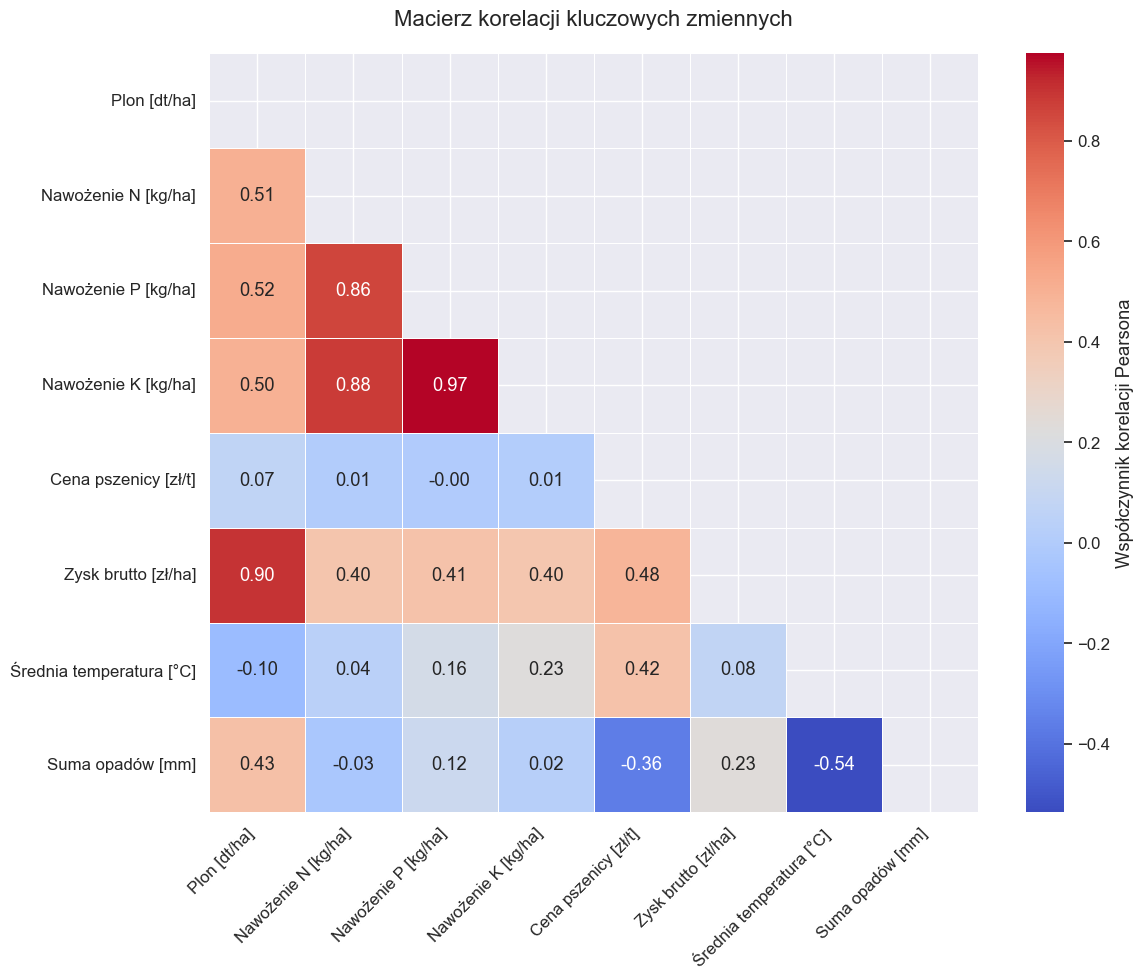

In [7]:
print("# Generowanie macierzy korelacji dla kluczowych zmiennych...")
zmienne_do_korelacji = [
    "Plon [dt/ha]",
    "Nawożenie N [kg/ha]",
    "Nawożenie P [kg/ha]",
    "Nawożenie K [kg/ha]",
    "Cena pszenicy [zł/t]",
    "Zysk brutto [zł/ha]",
    "Średnia temperatura [°C]",
    "Suma opadów [mm]"
]

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(font_scale=1.1)
macierz_korelacji = df[zmienne_do_korelacji].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(macierz_korelacji, dtype=bool))
sns.heatmap(macierz_korelacji, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5, mask=mask,
            cbar_kws={"label": "Współczynnik korelacji Pearsona"})
plt.title("Macierz korelacji kluczowych zmiennych", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "macierz_korelacji.png", dpi=300, bbox_inches="tight")
plt.show()


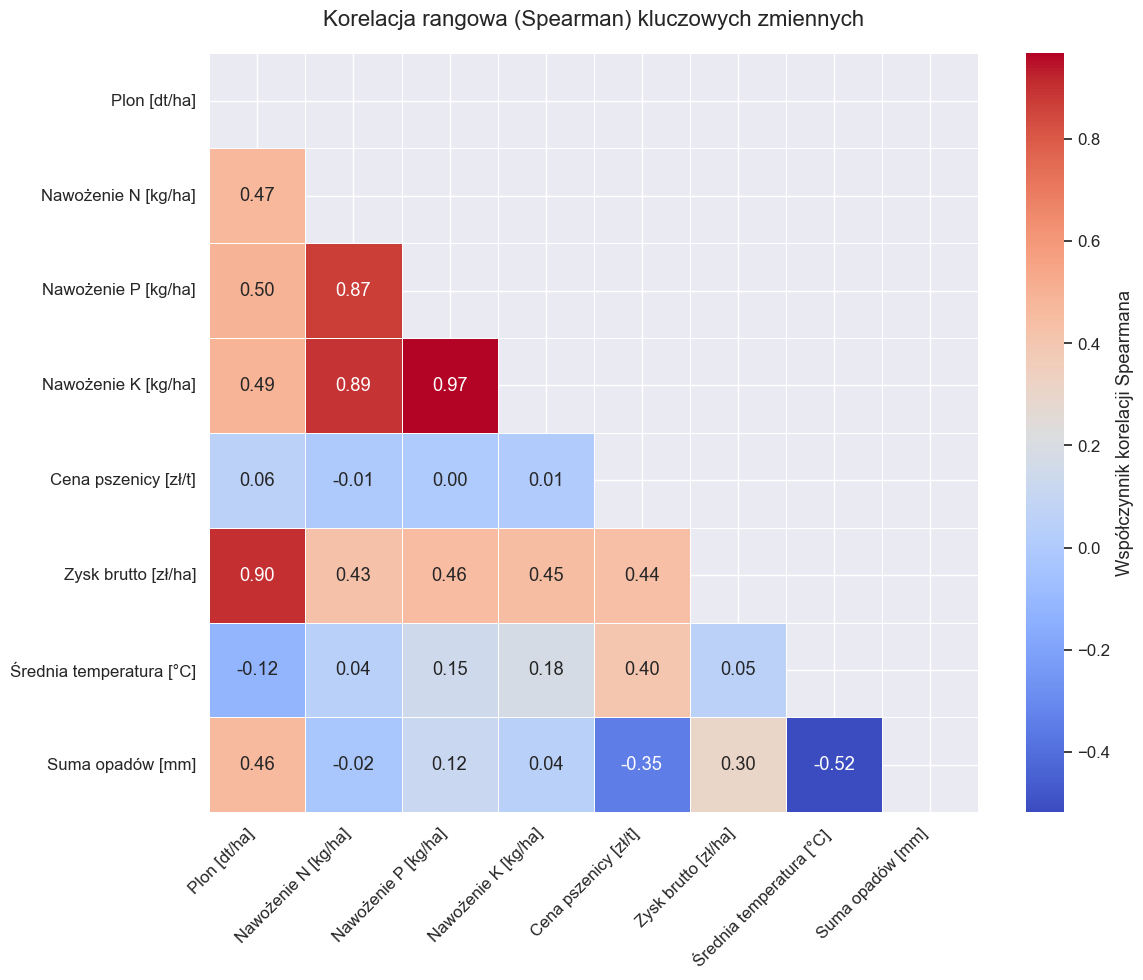

In [8]:
# Korelacja Spearmana (porządkowa/rangowa) - pokazuje zależności nieliniowe
plt.figure(figsize=(12, 10))
macierz_spearman = df[zmienne_do_korelacji].corr(method='spearman')
mask = np.triu(np.ones_like(macierz_spearman, dtype=bool))
sns.heatmap(macierz_spearman, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5, mask=mask,
            cbar_kws={"label": "Współczynnik korelacji Spearmana"})
plt.title("Korelacja rangowa (Spearman) kluczowych zmiennych", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "macierz_korelacji_spearman.png", dpi=300, bbox_inches="tight")
plt.show()


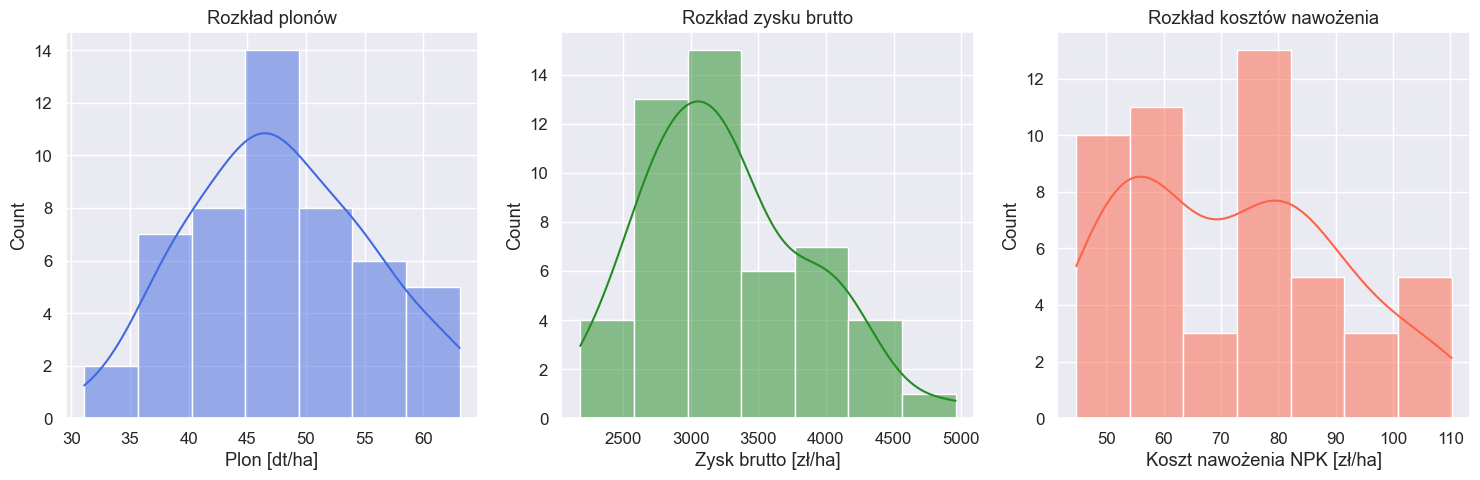

In [9]:
# Rozkłady kluczowych zmiennych ekonomicznych i plonów
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df["Plon [dt/ha]"], kde=True, color="royalblue")
plt.title("Rozkład plonów")

plt.subplot(1, 3, 2)
sns.histplot(df["Zysk brutto [zł/ha]"], kde=True, color="forestgreen")
plt.title("Rozkład zysku brutto")

plt.subplot(1, 3, 3)
sns.histplot(df["Koszt nawożenia NPK [zł/ha]"], kde=True, color="tomato")
plt.title("Rozkład kosztów nawożenia")

plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "histogramy_zmiennych.png", dpi=300, bbox_inches="tight")
plt.show()


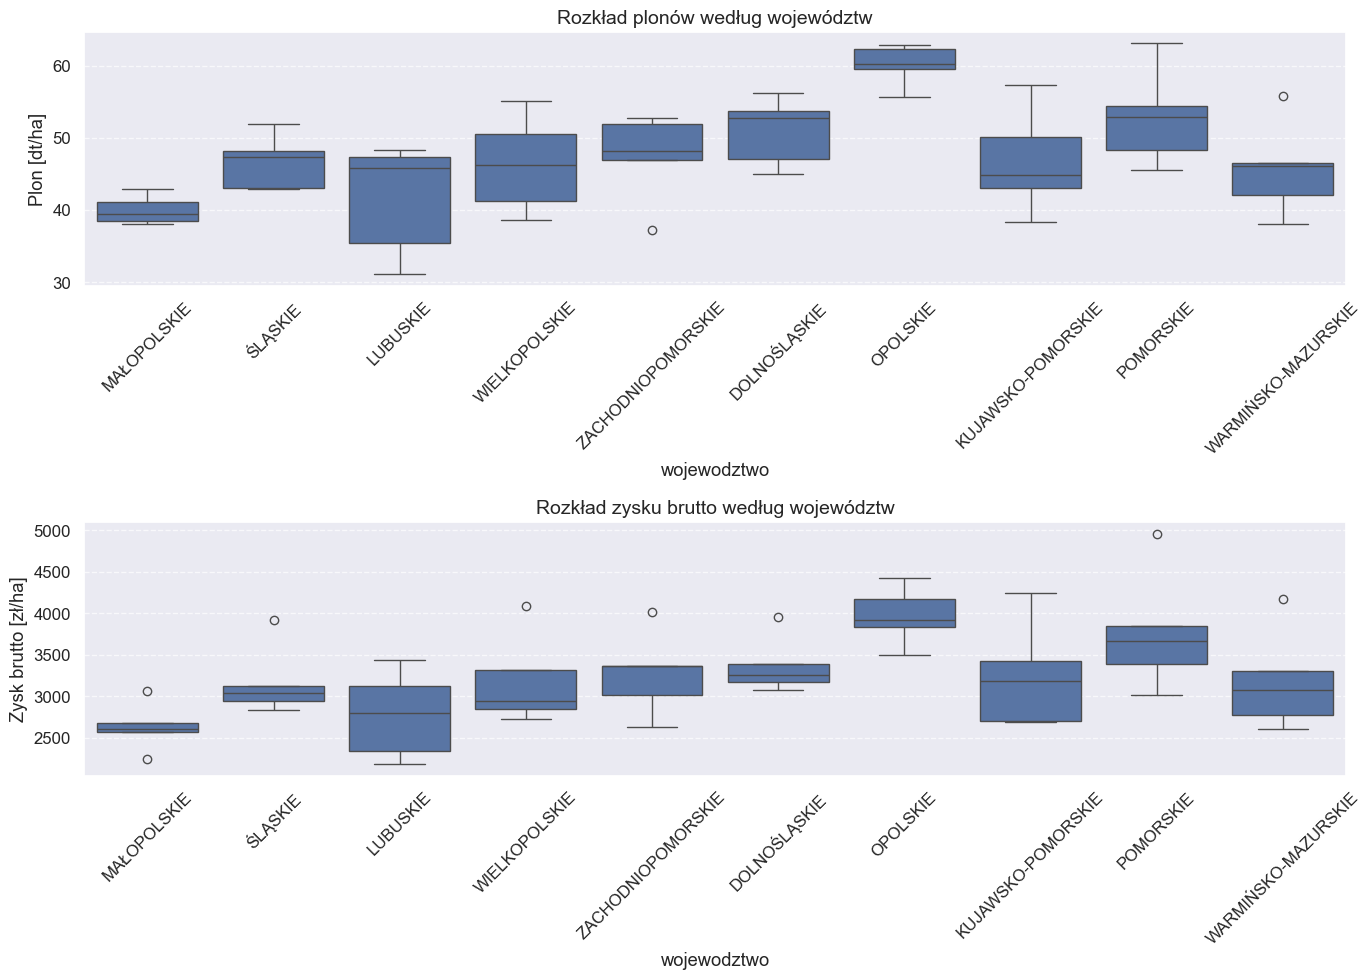

In [10]:
# Porównanie plonów i zysków między województwami
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.boxplot(data=df, x="wojewodztwo", y="Plon [dt/ha]")
plt.title("Rozkład plonów według województw", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
sns.boxplot(data=df, x="wojewodztwo", y="Zysk brutto [zł/ha]")
plt.title("Rozkład zysku brutto według województw", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "boxploty_wojewodztw.png", dpi=300, bbox_inches="tight")
plt.show()


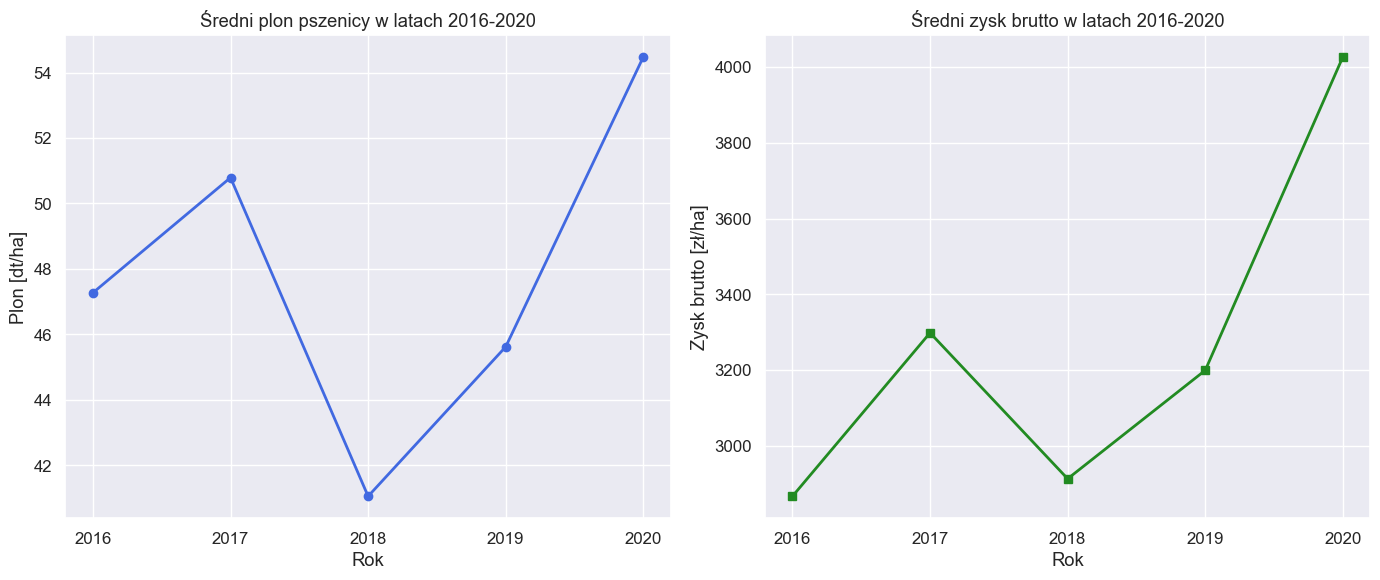

In [11]:
# Trendy czasowe plonów i kosztów nawożenia
plt.figure(figsize=(14, 6))

# Dane zagregowane wg roku - średnie wartości
df_rok = df.groupby('rok').agg({
    'Plon [dt/ha]': 'mean',
    'Koszt nawożenia NPK [zł/ha]': 'mean',
    'Zysk brutto [zł/ha]': 'mean'
}).reset_index()

lata = sorted(df_rok['rok'].unique())

plt.subplot(1, 2, 1)
plt.plot(df_rok['rok'], df_rok['Plon [dt/ha]'], marker='o', linewidth=2, color='royalblue')
plt.title('Średni plon pszenicy w latach 2016-2020')
plt.xlabel('Rok')
plt.ylabel('Plon [dt/ha]')
plt.grid(True)
plt.xticks(lata)  # <-- tylko pełne lata jako

plt.subplot(1, 2, 2)
plt.plot(df_rok['rok'], df_rok['Zysk brutto [zł/ha]'], marker='s', linewidth=2, color='forestgreen')
plt.title('Średni zysk brutto w latach 2016-2020')
plt.xlabel('Rok')
plt.ylabel('Zysk brutto [zł/ha]')
plt.grid(True)
plt.xticks(lata)  # <-- tylko pełne lata

plt.tight_layout()
plt.savefig(SCIEZKA_WYKRESOW / "trendy_czasowe.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
# Pairplot dla zmiennych związanych z nawożeniem i plonem
sns_plot = sns.pairplot(
    df[["Plon [dt/ha]", "Nawożenie N [kg/ha]", "Nawożenie P [kg/ha]", "Nawożenie K [kg/ha]"]],
    diag_kind="kde",
    corner=True
)
sns_plot.fig.suptitle("Pairplot kluczowych cech nawożenia i plonu", y=1.02)
sns_plot.savefig(SCIEZKA_WYKRESOW / "pairplot_nawozenie.png", dpi=300)
plt.close()

## 1.8. Zapis wyników


In [13]:
print("# Zapisywanie zintegrowanego panelu danych...")
plik_pelen = SCIEZKA_PRZETWORZONYCH / "panel_agroekonomiczny.csv"
df.to_csv(plik_pelen, index=False)
print(f"# Pełny panel danych zapisano w: {plik_pelen}")

# Zapisywanie zintegrowanego panelu danych...
# Pełny panel danych zapisano w: ..\data\processed\panel_agroekonomiczny.csv
